In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt


random.seed(4) #for reproducability
chunk_size = 256 #configure as needed

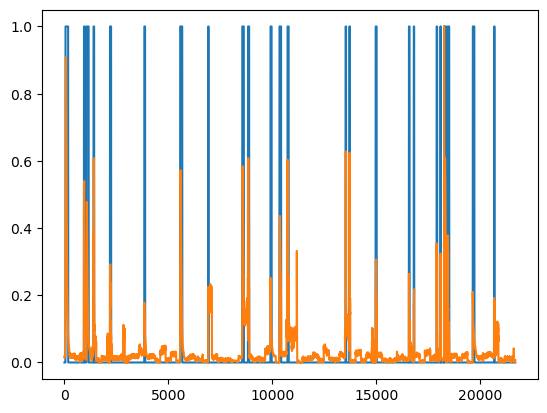

In [15]:
#pull dataframe, shuffle in chunks

df = pd.read_csv('processed.csv', chunksize=chunk_size, iterator=True) #df is now a TextFileReader dtype

allchunks = [pd.DataFrame(chunk) for chunk in df] #the df is now a list of smaller dfs, each as big as chunk_size
random.shuffle(allchunks) #shuffle the list
sdf = pd.concat(allchunks, ignore_index=True) #put it back together, fix index

plt.plot(sdf.index, sdf['Fire'], sdf['1.0 std'])

In [17]:
#reshaping dataframe, pull X and y
columns_for_train = ['1.0 std','2.5 std', '10 std'] #choose what to train on

X = sdf.loc[:, columns_for_train] #dataframe with only these columns
y = sdf.loc[:, ['Fire']] #dataframe for output

X, y = X.to_numpy(), y.to_numpy() #convert to numpy arrays

y = y.flatten() #reshaping each
X = X.reshape((X.shape[0], X.shape[1], 1))

print(len(X))

21684


In [7]:
#split into train, validation, and test for X and y


train_size = int(len(allchunks)*0.7) * chunk_size #70% of data, ensures a chunk wont get broken up during train/val/test split
val_size = int(len(allchunks)*0.2) * chunk_size #20%
#test data is just the rest (not exactly 10% due to rounding)


X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]


X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((15104, 3, 1), (15104,), (4352, 3, 1), (4352,), (2226, 3, 1), (2226,))

In [9]:
model = keras.Sequential()
model.add(keras.Input(shape=(3, 1))) #no specific amount of timesteps, 3 pixels in each row/timestep
model.add(layers.GRU(512, return_sequences=True, activation='relu')) #returns the output of each timestep so we can stack multiple RNN layers
model.add(layers.GRU(256, activation='relu')) #no return sequences so that normal dense layers can proceed it
model.add(layers.Dense(2))

#could do LSTM, GRU, or RNN and can change by literally just swapping them out

print(model.summary())

#RNNs typically use tanh instead of relu

model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), #fromlogits is true since we don't have softmax activation in final dense layer
    optimizer=keras.optimizers.Adam(learning_rate=0.001), #dont make learning rate too high or will result in overfitment of training data
    metrics=['accuracy']
)

model.fit(X_train, y_train, batch_size=32, validation_data=(X_val, y_val),epochs=10, verbose=1)

model.evaluate(X_test, y_test, batch_size=32, verbose=1)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 3, 512)         │       791,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 256)            │       591,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,382,914 (5.28 MB)

 Trainable params: 1,382,914 (5.28 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
472/472 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.9577 - loss: 0.1573 - val_accuracy: 0.9412 - val_loss: 0.1260
Epoch 2/10
472/472 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9786 - loss: 0.0572 - val_accuracy: 0.9432 - val_loss: 0.1092
Epoch 3/10
472/472 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9773 - loss: 0.0555 - val_accuracy: 0.9423 - val_loss: 0.1306
Epoch 4/10
472/472 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9790 - loss: 0.0546 - val_accuracy: 0.9515 - val_loss: 0.1007
Epoch 5/10
472/472 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9809 - loss: 0.0491 - val_accuracy: 0.9465 - val_loss: 0.1036
Epoch 6/10
472/472 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9824 - loss: 0.0482 - val_accuracy: 0.9465 - val_loss: 0.1107
Epoch 7/10
472/472 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9820 - loss: 0.0459 - val_accuracy: 0.9458 - val_loss: 0.1092
Epoch 8/10
472/472 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9823 - loss: 0.0477 - va

[0.011110730469226837, 0.9964061379432678]